In [16]:
import re
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/madson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def substitui_arroba(text):
    arrobas = re.findall(r"@\w+", text)
    for arroba in arrobas:
        text = text.replace(arroba, "[sujeito]")
    return text

In [3]:
df = (
    pd
    .read_csv("../data/raw/NoThemeTweets.csv")
    .drop(columns=["id", "tweet_date", "query_used"], axis=1)
)

In [19]:
df.head()

,tweet_text,sentiment,original,tamanho
0,[sujeito] 14 para eu ir :),Positivo,@Tixaa23 14 para eu ir :),25
1,[sujeito] O meu like eu já dei na época :),Positivo,@drexalvarez O meu like eu já dei na época :),45
2,Eu só queria conseguir comer alguma coisa pra ...,Positivo,Eu só queria conseguir comer alguma coisa pra ...,61
3,:D que lindo dia !,Positivo,:D que lindo dia !,18
4,"[sujeito] Pq da pr jeito!!é uma ""oferta"", ha q...",Positivo,"@Primo_Resmungao Pq da pr jeito!!é uma ""oferta...",68


In [7]:
df = df.assign(
    original = df.tweet_text,
    tamanho = df.tweet_text.apply(len),
    tweet_text = df.tweet_text.apply(substitui_arroba)
)

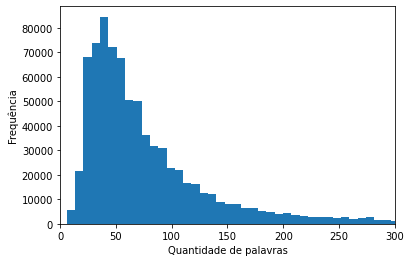

In [8]:
plt.hist(df.tamanho, bins=100)
plt.xlabel("Quantidade de palavras")
plt.ylabel("Frequência")
plt.xlim([0, 300])
plt.show()

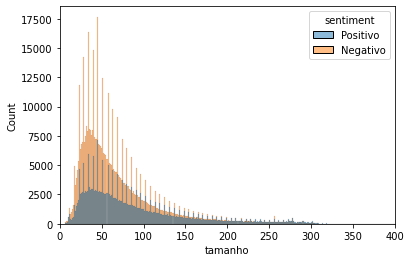

In [9]:
sns.histplot(data=df, x="tamanho", hue="sentiment")
plt.xlim(0, 400)
plt.show()

In [36]:
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords.append("[sujeito]")


positive_text = " ".join(df.query("sentiment == 'Positivo'").original)
negative_text = " ".join(df.query("sentiment == 'Negativo'").original)
negative_filter = ' '.join(list(filter(lambda x: x not in stopwords, negative_text.split())))

In [37]:
# Generate a word cloud image
wordcloud = WordCloud().generate(negative_filter)

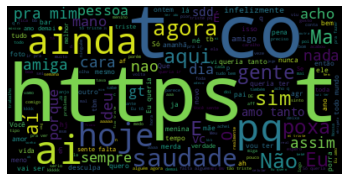

In [38]:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()